In [1]:
from torch.distributed.rpc import RRef
from src.environments.generic_environments import *
from src.models.gp_model import get_graph_key, gather_data
from src.abci_dibs_gp import ABCIDiBSGP as ABCI

Detecting 1 CUDA device(s).


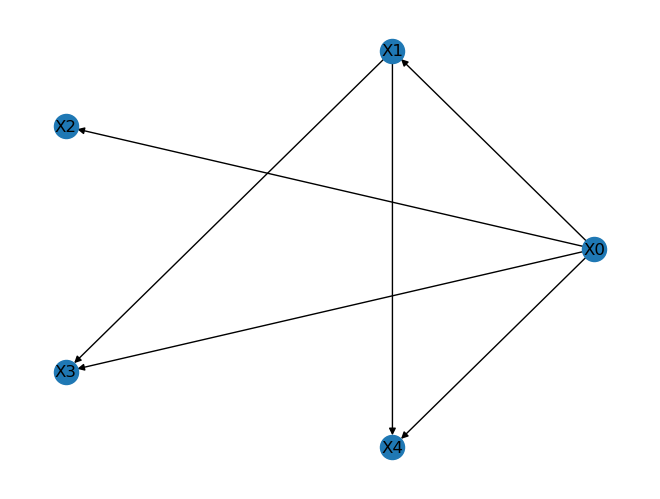

In [2]:
import matplotlib.pyplot as plt
import torch.distributions as dist
from matplotlib.ticker import MaxNLocator

from src.abci_dibs_gp import ABCIDiBSGP as ABCI
from src.environments.generic_environments import *
from src.models.gp_model import *

# specify the number of nodes and (optionally) a query of interventional variables
num_nodes = 5
interventional_queries = None
# interventional_queries = [InterventionalDistributionsQuery(['X2'], {'X1': dist.Uniform(2., 5.)})]

# generate the ground truth environment
env = BarabasiAlbert(num_nodes,
            num_test_queries=50,
            interventional_queries=interventional_queries)

# plot true graph
nx.draw(env.graph, nx.circular_layout(env.graph), labels=dict(zip(env.graph.nodes, env.graph.nodes)))

In [3]:
policy = 'graph-info-gain'
abci = ABCI(env, policy, num_particles=5, num_mc_graphs=40, num_workers=1, dibs_plus=True, linear=False)

num_experiments = 2
batch_size = 3

abci.run(num_experiments, batch_size, num_initial_obs_samples=3)

Starting experiment cycle 1/2...
Design and perform experiment...
Updating latent particles via SVGD...
Updating 80 GP's hyperparams with first 1 experiments.
Step 1 of 500, negative log posterior is 33.2621955871582...
Step 26 of 500, negative log posterior is 28.465557098388672...
Step 51 of 500, negative log posterior is 27.937259674072266...
Stopping particle updates early in iteration 54 after improvement stagnates...
Discarding 0 old mechanisms...
Discarding 0 old topological orders...
There are currently 80 unique mechanisms in our model...
Logging evaluation stats...
Experiment 1/2, ESHD is 4.894453525543213
Starting experiment cycle 2/2...
Design and perform experiment...
Expected information gain for observational sample is 1.0186046361923218.
Start experiment design for node X0 at 16:43:58


The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
Input data is not contained to the unit cube. Please consider min-max scaling the input data.
Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
Keyword arguments ['maxiter', 'disp'] will be ignored because they are not allowed parameters for function Adam. Allowed parameters are ['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'foreach', 'maximize', 'capturable', 'differentiable', 'fused'].
Keyword arguments ['lr', 'disp'] will be ignored because they are not allowed parameters for function ExpMAStoppingCriterion. Allowed parameters are ['maxiter', 'minimize', 'n_window', 'eta', 'rel_tol'].


Expected information gain for {'X0': tensor(-6.5103)} is 1.4354569911956787.
Start experiment design for node X4 at 16:44:09
Expected information gain for {'X4': tensor(-1.5714)} is 0.7856985330581665.
Start experiment design for node X1 at 16:44:18
Expected information gain for {'X1': tensor(5.2857)} is 1.2573803663253784.
Start experiment design for node X3 at 16:44:27
Expected information gain for {'X3': tensor(-5.5714)} is 1.2830290794372559.
Start experiment design for node X2 at 16:44:37
Expected information gain for {'X2': tensor(-4.1429)} is 0.9917783737182617.
Resampling particles [4, 1, 3] according to weights tensor([0.2296, 0.1285, 0.3004, 0.1138, 0.2277]) (kept 2/2
Discarding 80 old mechanisms...
Discarding 636 old topological orders...
Updating latent particles via SVGD...
Updating 72 GP's hyperparams with first 2 experiments.
Step 1 of 500, negative log posterior is 62.633277893066406...
Updating 5 GP's hyperparams with first 2 experiments.
Updating 1 GP's hyperparams wi

Number of observational batches: 1
Number of interventional batches on X0: 1
Number of interventional batches on X1: 0
Number of interventional batches on X2: 0
Number of interventional batches on X3: 0
Number of interventional batches on X4: 0


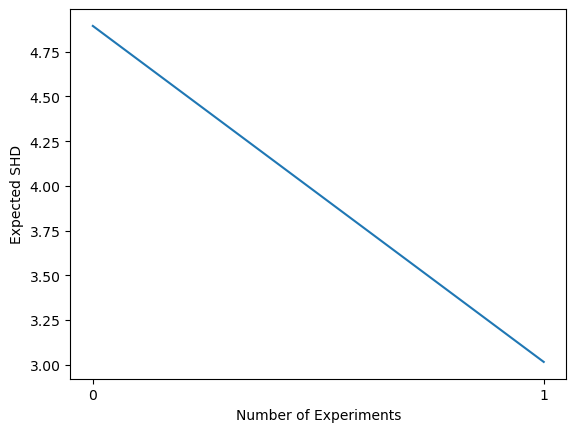

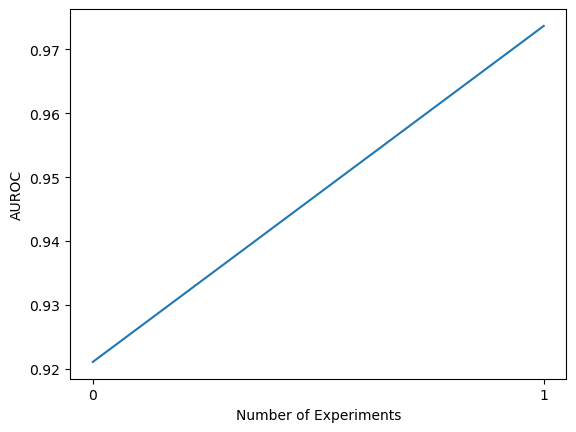

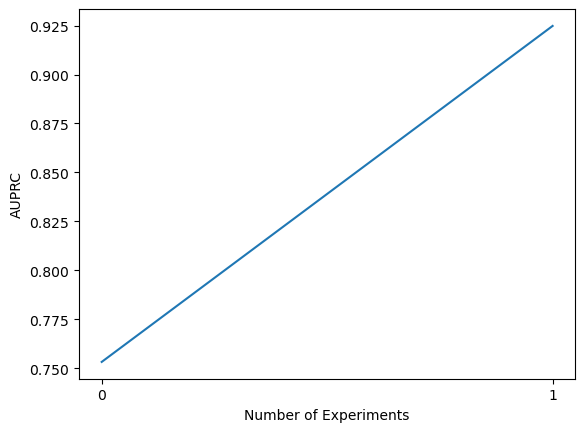

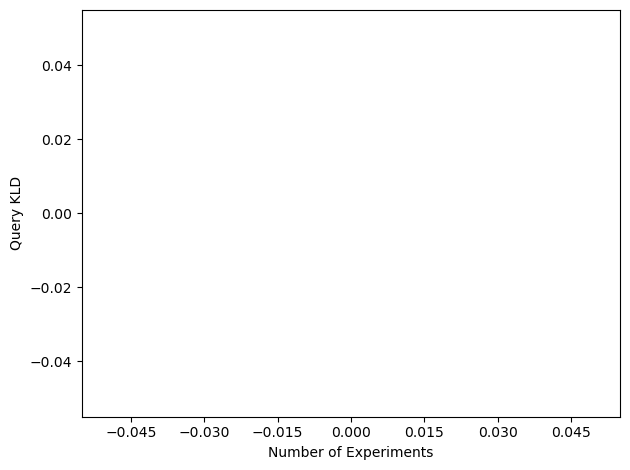

In [4]:
print(f'Number of observational batches: {len([e for e in abci.experiments if e.interventions == {}])}')
for node in env.node_labels:
    print(
        f'Number of interventional batches on {node}: {len([e for e in abci.experiments if node in e.interventions])}')

# plot expected SHD over experiments
ax = plt.figure().gca()
plt.plot(abci.eshd_list)
plt.xlabel('Number of Experiments')
plt.ylabel('Expected SHD')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# plot auroc over experiments
ax = plt.figure().gca()
plt.plot(abci.auroc_list)
plt.xlabel('Number of Experiments')
plt.ylabel('AUROC')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# plot auprc over experiments
ax = plt.figure().gca()
plt.plot(abci.auprc_list)
plt.xlabel('Number of Experiments')
plt.ylabel('AUPRC')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# plot Query KLD over experiments
ax = plt.figure().gca()
plt.plot(abci.query_kld_list)
plt.xlabel('Number of Experiments')
plt.ylabel('Query KLD')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

In [20]:
from rpy2.robjects.packages import importr

sl3 = importr('AER')

R[write to console]: Error: package or namespace load failed for ‘zoo’ in library.dynam(lib, package, package.lib):
 shared object ‘lattice.so’ not found

R[write to console]: Failed with error:  
R[write to console]: 
R[write to console]: ‘package ‘zoo’ could not be loaded’
R[write to console]: 
R[write to console]: 

R[write to console]: Error in library.dynam(lib, package, package.lib) : 
  shared object ‘lattice.so’ not found



RRuntimeError: Error in library.dynam(lib, package, package.lib) : 
  shared object ‘lattice.so’ not found


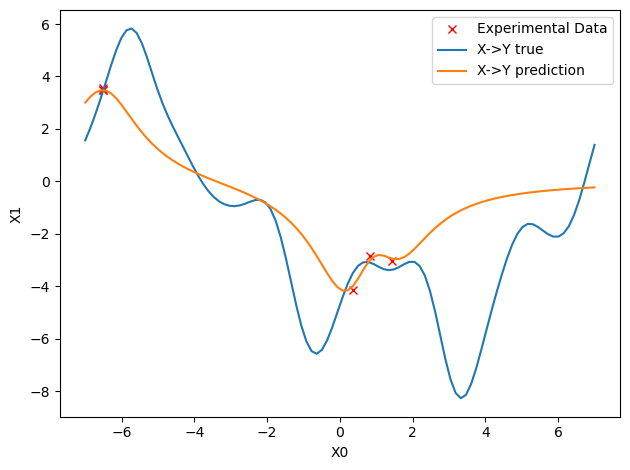

In [6]:
# plot X_i -> X_j true vs. predicted
i = 0
j = 1
xdata, ydata = gather_data(abci.experiments, f'X{j}', parents=[f'X{i}'])
xrange = torch.linspace(-7., 7., 100).unsqueeze(-1)
ytrue = env.mechanisms[f'X{j}'](xrange).detach()
mech = abci.mechanism_model.get_mechanism(f'X{j}', parents=[f'X{i}'])
mech.set_data(xdata, ydata)
ypred = mech(xrange).detach()

plt.figure()
plt.plot(xdata, ydata, 'rx', label='Experimental Data')
plt.plot(xrange, ytrue, label='X->Y true')
plt.plot(xrange, ypred, label='X->Y prediction')
plt.xlabel(f'X{i}')
plt.ylabel(f'X{j}')
plt.legend()
plt.tight_layout()